This is my final project for the Udemy 'Complete Course on Product A/B Testing with Interview Guide'. The course itself is taught in R but I wanted to complete the project in Python. I will not provide the dataset for the course in the Repo since it is a paid course.

## The brief for the final project:  

> We are an **online retailer** that sells home decor both through our website and our app. The company recently added lamps as a new category of prodcuts which were not being sold before. In order to generate awareness and boost sales, we want to do a promotion through our app. Sending users a notification has had good success in the past and they are considering a 10 dollar discount through an **in-app notification**. At the same time we know that the lifetime value (LTV) of a customer who has installed the app is much higher. Therefore the product group wants to be careful to **not drive users to uninstall the app** using an in-app notification for the discount.


Before rolling out the change, the product team would be more comfortable testing the notification on a small number of users to see how it performs, so you suggest running an **A/B test** on a subset of your user base users.

#### Our goal is to run an A/B test to:
1. See if our transaction rate will increase for the test group. (% of users that will make a purchase)
2. See if our purchase value goes up for our test group.
3. Verify that our uninstall rate does not go up due to the test.

In [1]:
# Package imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from IPython.display import Image

In [2]:
# Import the dataframe
df = pd.read_csv('_AB_Test_Data.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   userid            100000 non-null  int64  
 1   allocation        100000 non-null  object 
 2   active_6m         100000 non-null  int64  
 3   days_since        100000 non-null  int64  
 4   addtocart_flag    100000 non-null  int64  
 5   transaction_flag  100000 non-null  int64  
 6   purchase_value    13820 non-null   float64
 7   uninstall_flag    100000 non-null  int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 6.1+ MB


In [3]:
# Verfiy that both groups have an equal amount of users.
df['allocation'].value_counts()

control      50000
treatment    50000
Name: allocation, dtype: int64

We need to choose the correct sample size for our population. Running the R code from the course I returned a value of 3792. 


You could also use Evan Miller's website (https://www.evanmiller.org/ab-testing/sample-size.html) to calculate the sample size.

Below is the R code for coming up with the sample, and how to calculate it in python.

control = 0.101 <br>
uplift = .2<br>
variant = (1 + uplift)*control<br>
effect_size <- ES.h(control, variant)<br>
sample_size_output <- pwr.2p.test(h = effect_size,<br>
&emsp;&emsp;&emsp;                                 n = ,<br>
&emsp;&emsp;&emsp;                                 sig.level = 0.05,<br>
&emsp;&emsp;&emsp;                                 power = 0.8)<br>
<br>
sample_size_output <- ceiling(sample_size_output$n)<br>
sample_size_output<br>
3792


In [4]:
# We need to calculate the value of the variant from above. This will be our second proportion effect size value

p1 = 0.101
uplift = 0.2
p2 = (1+uplift)*p1
p2

0.1212

In [5]:
# Calculate sample size for an increase in conversion rate from 10% to 12%

effect_size = sms.proportion_effectsize(p1, p2)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

3792


In [6]:
df.describe()

,userid,active_6m,days_since,addtocart_flag,transaction_flag,purchase_value,uninstall_flag
count,1.000000e+05,100000.000000,100000.00000,100000.000000,100000.000000,13820.000000,100000.000000
mean,6.875314e+05,0.750000,135.23761,0.256340,0.138200,304.575678,0.040100
std,4.059202e+05,0.433015,98.70948,0.436614,0.345112,117.433206,0.196195
min,1.700000e+01,0.000000,2.00000,0.000000,0.000000,10.997424,0.000000
25%,3.352480e+05,0.750000,60.00000,0.000000,0.000000,226.159724,0.000000
50%,6.724380e+05,1.000000,112.00000,0.000000,0.000000,306.698469,0.000000
75%,1.042749e+06,1.000000,180.25000,1.000000,0.000000,384.047570,0.000000
max,1.407576e+06,1.000000,365.00000,1.000000,1.000000,961.996650,1.000000


Let's look at some quick summary stastics for the entire population.

75% of users have been active in the last 6 months<br>
26% of users have added an item from the lamp category to the cart<br>
14% have purchased from the lamp category<br>
Avg purchase value is 305 dollars<br>
4% of users have uninstalled<br>

For the test we are going to remove any users who appeared more than once.

In [7]:
user_counts = df['userid'].value_counts(ascending=False)
multi_users = user_counts[user_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 14542 users that appear multiple times in the dataset


In [8]:
users_to_drop = user_counts[user_counts > 1].index

df = df[~df['userid'].isin(users_to_drop)]
print(f'The updated dataset now has {df.shape[0]} entries')

The updated dataset now has 40371 entries


In [9]:
# Check the grouped users again
df['allocation'].value_counts()

control      20238
treatment    20133
Name: allocation, dtype: int64

There are enough users for each group I will continue. I also set the random state to 6 so you can get the same sample I did.

In [10]:
# lets make a sample for both groups
control_sample = df[df['allocation'] == 'control'].sample(n=required_n, random_state = 6)
treatment_sample = df[df['allocation'] == 'treatment'].sample(n=required_n, random_state = 6)

sample_group = pd.concat([control_sample, treatment_sample], axis=0)
sample_group.reset_index(drop=True, inplace=True)

In [11]:
# verify both groups have the same number of users
sample_group['allocation'].value_counts()

treatment    3792
control      3792
Name: allocation, dtype: int64

In [12]:
transaction_flag = sample_group.groupby('allocation')['transaction_flag']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

transaction_flag = transaction_flag.agg([np.mean, std_p, se_p])
transaction_flag.columns = ['transaction_flag', 'std_deviation', 'std_error']


transaction_flag.style.format('{:.3f}')

,transaction_flag,std_deviation,std_error
allocation,,,
control,0.096,0.295,0.005
treatment,0.173,0.378,0.006


Our control group had a 10% chance of a transaction with the treatment group having a 17% transaction chance

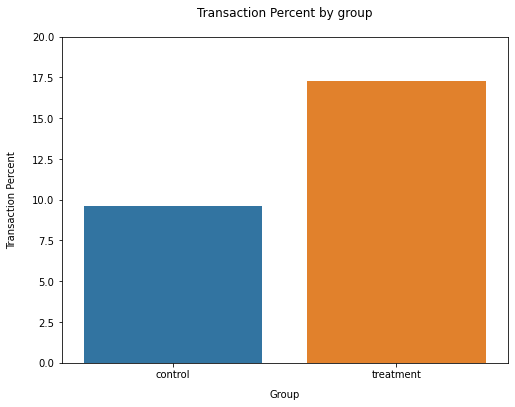

In [13]:
plt.figure(figsize=(8,6))

sns.barplot(x=sample_group['allocation'], y=sample_group['transaction_flag']*100, ci=False)

plt.ylim(0, 20)
plt.title('Transaction Percent by group', pad=20)
plt.xlabel('Group', labelpad=10)
plt.ylabel('Transaction Percent', labelpad=15);

In [14]:
control_transaction_results = sample_group[sample_group['allocation'] == 'control']['transaction_flag']
treatment_transaction_results = sample_group[sample_group['allocation'] == 'treatment']['transaction_flag']

n_con = control_transaction_results.count()
n_treat = treatment_transaction_results.count()
successes = [control_transaction_results.sum(), treatment_transaction_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -9.83
p-value: 0.000
ci 95% for control group: [0.087, 0.105]
ci 95% for treatment group: [0.161, 0.185]


 It is stastically significant but we need to check if our uninstalls went up. Since we do not want our uninstalls to go up by using a notification system.

In [15]:
sample_group.groupby(by=["allocation"])[["addtocart_flag", "transaction_flag", "purchase_value", "uninstall_flag"]].mean()

,addtocart_flag,transaction_flag,purchase_value,uninstall_flag
allocation,,,,
control,0.222838,0.095992,269.147085,0.028217
treatment,0.280854,0.172996,319.391390,0.055116


In [16]:
treatment_df = sample_group[sample_group["allocation"] == "treatment"]
control_df = sample_group[sample_group["allocation"] == "control"]

treatment_df[["addtocart_flag", "transaction_flag", "purchase_value", "uninstall_flag"]].mean() - control_df[["addtocart_flag", "transaction_flag", "purchase_value", "uninstall_flag"]].mean()

addtocart_flag       0.058017
transaction_flag     0.077004
purchase_value      50.244305
uninstall_flag       0.026899
dtype: float64

This means that the treatment group had a 6% higher add to cart flag or 6% higher chance of adding a lamp to their cart. <br>
The treatment group had a 8% higher chance of purchasing lamp. <br>
The treatment group also spent $50.244 more than the control group. <br>
Finally the treatment group had a 3% higher uninstall rate, this means we would not push out the new notification to users as the goal was to not increase our uninstall rate for this test.

In [17]:
control_uninstall_flag = sample_group[sample_group['allocation'] == 'control']['uninstall_flag']
treatment_uninstall_flag = sample_group[sample_group['allocation'] == 'treatment']['uninstall_flag']

n_con = control_uninstall_flag.count()
n_treat = treatment_uninstall_flag.count()
successes = [control_uninstall_flag.sum(), treatment_uninstall_flag.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -5.86
p-value: 0.000
ci 95% for control group: [0.023, 0.033]
ci 95% for treatment group: [0.048, 0.062]


### Final Remarks:

Our uninstall rate for the control group was 2% to 3%
While the uninstall rate for the notification group was 5% to 6%

Therefore with a 3% increased uninstall rate we would not roll out the notification.